# Creating a web-based RAG pipeline


In [1]:
import os
from dotenv import load_dotenv

load_dotenv('../.env')

True

_Using LLAMA_ (for llm)

In [23]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="meta/llama3-70b-instruct")

In [24]:
llm.invoke('what is sakuga?')

AIMessage(content='Sakuga () is a Japanese term that refers to the artistic and technical aspects of anime production, particularly the process of creating high-quality, detailed, and often elaborate animation sequences. The word "sakuga" is derived from the Japanese words "saku," meaning "to draw" or "to create," and "ga," meaning "picture" or "image."\n\nIn the anime industry, sakuga refers to the craftsmanship and expertise of keyframe animators, in-betweeners, and other animation staff who work together to create visually stunning and engaging animation sequences. These sequences often feature complex character movements, detailed backgrounds, and innovative visual effects.\n\nSakuga is characterized by:\n\n1. High-quality drawing and animation techniques\n2. Attention to detail and texture\n3. Innovative use of camera angles and movement\n4. Emphasis on dynamic action sequences and dramatic poses\n5. Often features "sakuga-esque" moments, such as:\n\t* Extreme close-ups\n\t* Dynam

In [25]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embeddings = NVIDIAEmbeddings(model="NV-Embed-QA")

_Using FAISS_ (for vectorDB)

In [26]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

#### RAG goes brrrrrrrrrrr

In [27]:
# import bs4
# from langchain import hub
# from langchain_community.document_loaders import WebBaseLoader
# from langchain_core.documents import Document
# from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langgraph.graph import START, StateGraph
# from typing_extensions import List, TypedDict

# # Load and chunk contents of the blog
# loader = WebBaseLoader(
#     web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
#     bs_kwargs=dict(
#         parse_only=bs4.SoupStrainer(
#             class_=("post-content", "post-title", "post-header")
#         )
#     ),
# )
# docs = loader.load()

# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
# all_splits = text_splitter.split_documents(docs)

# # Index chunks
# _ = vector_store.add_documents(documents=all_splits)

# # Define prompt for question-answering
# prompt = hub.pull("rlm/rag-prompt")


# # Define state for application
# class State(TypedDict):
#     question: str
#     context: List[Document]
#     answer: str


# # Define application steps
# def retrieve(state: State):
#     retrieved_docs = vector_store.similarity_search(state["question"])
#     return {"context": retrieved_docs}


# def generate(state: State):
#     docs_content = "\n\n".join(doc.page_content for doc in state["context"])
#     messages = prompt.invoke({"question": state["question"], "context": docs_content})
#     response = llm.invoke(messages)
#     return {"answer": response.content}


# # Compile application and test
# graph_builder = StateGraph(State).add_sequence([retrieve, generate])
# graph_builder.add_edge(START, "retrieve")
# graph = graph_builder.compile()

In [28]:
# response = graph.invoke({"question": "What is Task Decomposition?"})
# print(response["answer"])

## 1. Indexing

_Loading data_

In [29]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43131


In [30]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


_Chunking_

In [31]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


_Storing_

In [32]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['8ab9b76d-b40c-40fe-806e-d448ab33674f', '7096933b-0cc6-4b11-9051-bf3caefaf91a', '5e249c01-71f4-43f9-aaaa-249bb582aa5f']


## 2. Retrieval

In [33]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [34]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [35]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

_WITHOUT LANGRAPH_

In [19]:
# Without LangGraph
question = "What is generative agent?"

retrieved_docs = vector_store.similarity_search(question)
formatted_docs = "\n\n".join(doc.page_content for doc in retrieved_docs)
engineered_prompt = prompt.invoke({"question": question, "context": formatted_docs})
answer = llm.invoke(engineered_prompt)

In [20]:
print(f'Context: {formatted_docs}\n\n')
print(f'Answer: {answer}')

Context: Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)
This fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many others).
Proof-of-Concept Examples#
AutoGPT has drawn a lot of attention into the possibility of setting up autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format parsing.
Here is the system message used by AutoGPT, where {{...}} are user inputs:
You are {{ai-name}}, {{user-provided AI bot description}}.
Your decisions must always be made independently without seeking user assistance. Play to your strengths as an LLM and pursue simple strategies with no legal complications.

GOALS:

They also discussed the risks, esp

In [22]:
question="How can we build it?"

retrieved_docs = vector_store.similarity_search(question)
formatted_docs = "\n\n".join(doc.page_content for doc in retrieved_docs)
engineered_prompt = prompt.invoke({"question": question, "context": formatted_docs})
answer = llm.invoke(engineered_prompt)

print(f'Context: {formatted_docs}\n\n')
print(f'Answer: {answer}')

Context: Fig. 10. A picture of a sea otter using rock to crack open a seashell, while floating in the water. While some other animals can use tools, the complexity is not comparable with humans. (Image source: Animals using tools)
MRKL (Karpas et al. 2022), short for “Modular Reasoning, Knowledge and Language”, is a neuro-symbolic architecture for autonomous agents. A MRKL system is proposed to contain a collection of “expert” modules and the general-purpose LLM works as a router to route inquiries to the best suitable expert module. These modules can be neural (e.g. deep learning models) or symbolic (e.g. math calculator, currency converter, weather API).

You will get instructions for code to write.
You will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.
Make sure that every detail of the architecture is, in the end, implemented as code.
Think step by step and reason yourself to the right decisions to make sure we get it

_WITH LANGRAPH_

In [15]:
# With LangGraph

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [16]:
result = graph.invoke({"question": "What is Generative Agent Architecture?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 26661}, page_content='Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format parsing.\nHere is the system message used by AutoGPT, where {{...}} are user inputs:\nYou are {{ai-name}}, {{user-provided AI bot description}}.\nYour decisions must always be made independently without seeking user assistance. Play 

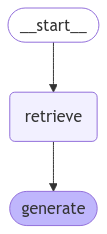

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# We can also do 'Query Analysis' for constrcuting optimized search queries on raw-user inputs.